# Note: this approach to the Spark Case Study uses DataFrames.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from datetime import datetime
import pandas as pd
import folium
from folium.plugins import HeatMap

plt.style.use('seaborn')

In [2]:
import pyspark as ps

spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("df case study") \
            .getOrCreate()

# 1. Read in the data

A single tweet is not as simple as one might expect; there are many nested fields in this data. Take a minute to look over the schema and get an idea of which ones are important. Note: it's quite large.

We might find the Twitter API docs of use: https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json

In [3]:
tweets_df = spark.read.json('./data/french_tweets.json')

# Format dates from 'created_at' column
date_format_udf = udf(lambda datecol: datetime.strptime(datecol, '%a %b %d %X %z %Y'), DateType())
tweets_df = tweets_df.filter(col('created_at').isNotNull()).withColumn('creation_date', date_format_udf(col('created_at')))
tweets_count = tweets_df.count()

print('Total tweet count: {}'.format(tweets_count))

Total tweet count: 214926


In [4]:
tweets_df.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

# 2. Count Tweets by User
What we'd like to do is start asking questions about how people are influenced by the election. We'll start by looking at the number of tweets on a per user basis. Create a histogram of tweets per user.

In [5]:
tweets_per_user = (tweets_df.groupby('user.name')
                   .agg(F.count('*').alias('count'))
                   .select('count')
                   .collect())   # Data is queried and collected into a list

tweets_per_user = [tw[0] for tw in tweets_per_user]   # Reformatted list

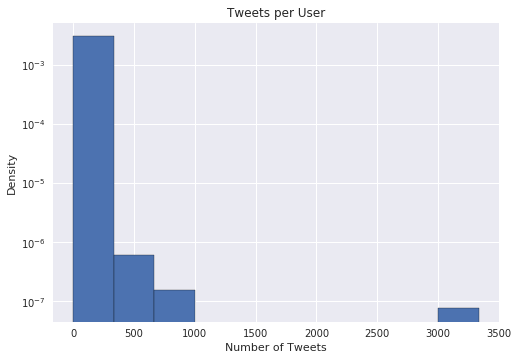

In [6]:
fig, ax = plt.subplots()
ax.hist(tweets_per_user, density=True, edgecolor='black')
ax.set_yscale('log')
ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Density')
_ = ax.set_title("Tweets per User")

# 3. Clean Data to Make a More Representative Distribution
This looks like a News organization.  Let's drop it and look at the remaining portion of the distribution.  Since we can see that even in the portion that will be left, there is most likely a very long tail.  Let's make two histograms, based on some split.

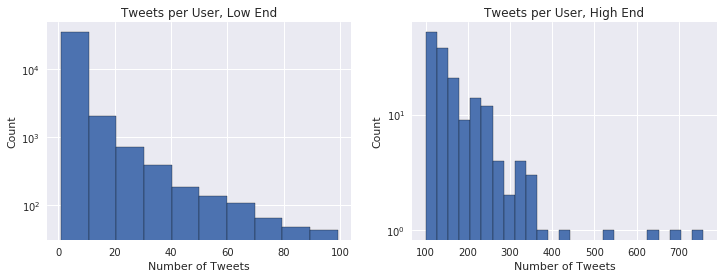

In [7]:
tweets_per_user = (tweets_df.groupby('user.name')
                   .agg(F.count('*').alias('count'))
                   .filter(col('count') < 2000)
                   .select('count')
                   .collect())

tweets_per_user = [tw[0] for tw in tweets_per_user]


fig, ax = plt.subplots(1,2,figsize=(12, 4))
ax[0].hist([x for x in tweets_per_user if x<100], bins=10, edgecolor='black')
ax[0].set_yscale('log')
ax[0].set_xlabel('Number of Tweets')
ax[0].set_ylabel('Count')
ax[0].set_title("Tweets per User, Low End")

ax[1].hist([x for x in tweets_per_user if x>100], bins = 25, edgecolor='black')
ax[1].set_yscale('log')
ax[1].set_xlabel('Number of Tweets')
ax[1].set_ylabel('Count')
_ = ax[1].set_title("Tweets per User, High End")

Let's do some more exploratory data analysis. When were these tweets made? Where? What languages are they in?

# 4. Tweet Context: When?

Our tweet data was posted over the course of a few days from the 26th-29th of April. This was during the [2017 French election](https://en.wikipedia.org/wiki/2017_French_presidential_election), after the initial April 23rd election (where nobody won a majority) and before the run-off on May 7th.

In [8]:
(tweets_df.filter(col('created_at').isNotNull()).groupby()
 .agg(F.min('creation_date'), F.max('creation_date')).show())

+------------------+------------------+
|min(creation_date)|max(creation_date)|
+------------------+------------------+
|        2017-04-26|        2017-04-29|
+------------------+------------------+



# 5. Tweet Context: Where?

In [9]:
coords_pd = tweets_df.filter(col('geo.coordinates').isNotNull()).select('geo.coordinates').toPandas()
coords_pd['lat'] = coords_pd['coordinates'].apply(lambda x: x[0])
coords_pd['lng'] = coords_pd['coordinates'].apply(lambda x: x[1])
coords_pd.drop('coordinates', inplace=True, axis=1)

print('{} tweets had coordinates'.format(coords_pd['lat'].count()))

18234 tweets had coordinates


Plot tweet locations on a map. This map is interactive and will not show in browser unless you are running in your own Jupyter Notebook.

In [10]:
EU_map = folium.Map(location=['47.0', '2.0'], tiles='Stamen Terrain', zoom_start=6)
HeatMap(data=coords_pd, radius=10, max_zoom=13).add_to(EU_map)

EU_map

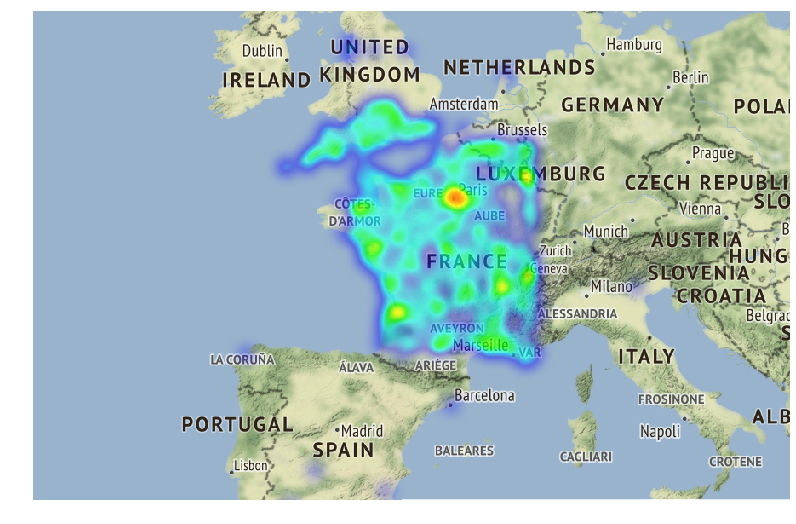

In [11]:
# Showing image for those not running the notebook
fig, ax = plt.subplots(figsize=(15, 9))

img = mpimg.imread('./img/Europe Heatmap.PNG')
plt.imshow(img)
_ = ax.axis('off')

The vast majority of these tweets come from France, with a notable proportion in the UK as well.

# 6. Tweet Context: What languages?

There are 47 languages in our dataset.


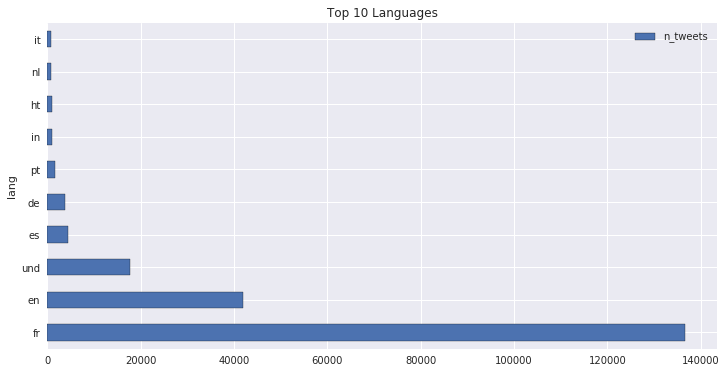

In [12]:
lang_count = tweets_df.select('lang').distinct().count()
print('There are {} languages in our dataset.'.format(lang_count))

lang_pd = (tweets_df.groupby('lang').
           agg(F.count('lang').alias('n_tweets')).
           orderBy('n_tweets', ascending=False).
           limit(10).toPandas())

_ = lang_pd.plot.barh(x='lang', y='n_tweets', figsize=(12,6), edgecolor='black', title='Top 10 Languages')

The languages are overwhelmingly French with a small amount of English. This aligns with our heatmap quite nicely. Now let's look at a few English tweets just for fun.

In [13]:
tweets_df.createOrReplaceTempView("tweets")

example_tweets = spark.sql("""SELECT text FROM tweets
                              WHERE lang = 'en'""") \
                      .sample(withReplacement=False, fraction=0.03, seed=8191918).limit(5).collect()

for i, tweet in enumerate(example_tweets):
    print('tweet {}: {}\n'.format(i, tweet[0]))

tweet 0: @ChassNews Ooops! He was celebrating victory at Café de la Rotonde 🤦‍♂️🤦‍♂️🤦‍♂️

tweet 1: Working lunch in the back garden ☀️#workinglunch #farmlife #picnic #lake #dorset #swanage… https://t.co/B2REZqvZgJ

tweet 2: Climbed those cliffs down! Those cliffs are sharp 😳Still definitely worth it 😃 #Cornwall #dayoff #filming… https://t.co/3Cb9u0oY1Q

tweet 3: Erik Schäfer, a partner at Cohausz&amp;Florack, speaks on the technological aspects pertaining to the role of… https://t.co/4Ece2w0mKk

tweet 4: @bill_russell3 @_aylesbury A shame more people don't want to do it, especially some of the more vociferous complainers



# 7. The 2017 Election

These tweets were made in the middle of the French election. There are many things we could look into, but we'll choose the candidates themselves - Emmanuel Macron and Marine Le Pen.

In [14]:
macron_counts = spark.sql("""SELECT text FROM tweets
                             WHERE LOWER(text) LIKE '%macron%'""").count()

lepen_counts = spark.sql("""SELECT text FROM tweets
                            WHERE LOWER(text) LIKE '%le pen%'
                            OR LOWER(text) LIKE '%lepen%'""").count()

both_counts = spark.sql("""SELECT text FROM tweets
                           WHERE LOWER(text) LIKE '%macron%'
                           AND (LOWER(text) LIKE '%le pen%'
                               OR LOWER(text) LIKE '%lepen%')""").count()

mac_lep_counts = macron_counts + lepen_counts - both_counts
print('{:1.2%} of all tweets were about these candidates'.format(mac_lep_counts/tweets_count))

4.52% of all tweets were about these candidates


Note: some tweets will refer to both candidates. We do a pivot in Pandas to show the mentions of each candidate by themselves as well as where they were mentioned together.

In [15]:
candidate_pd = pd.DataFrame({'Candidate': ['Macron', 'Le Pen', 'Macron', 'Le Pen'],
                             'Type': ['Candidate Only', 'Candidate Only', 'Both', 'Both'],
                             'Mentions': [macron_counts - both_counts, lepen_counts - both_counts, both_counts, both_counts]})

pivot = candidate_pd.pivot(index='Candidate', columns='Type', values='Mentions')
pivot = pivot.iloc[:, [1, 0]]
pivot.head()

Type,Candidate Only,Both
Candidate,,
Le Pen,2021,842
Macron,6847,842


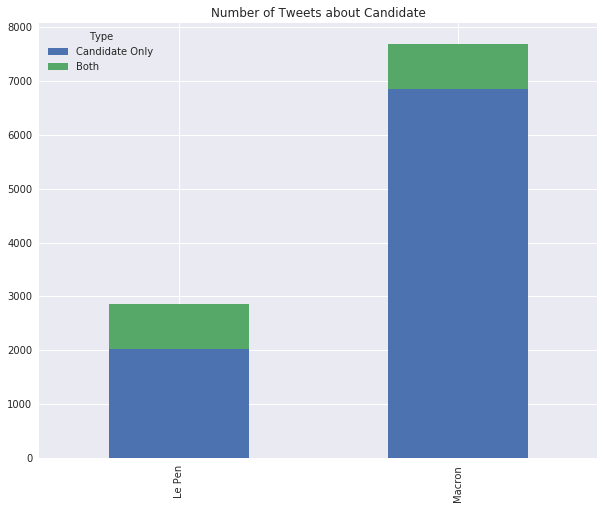

In [16]:
ax = pivot.plot.bar(stacked=True, figsize=(10, 8), title='Number of Tweets about Candidate')

x_axis = ax.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)

This shows people were talking much more about Macron than Le Pen. Interestingly, these results are similar to the results in the election at 66% Macron to 34% Le Pen.